# Model Optimization and Nonlinear Models

CSC/DSC 340 Week 5 Lecture Notes

Author: [Dr. Julie Butler](www.juliebutler.org)

Date Created: August 20, 2023

Last Modified: August 20, 2023

## Part 1: Hyperparameter Tuning

### Why do we need hyperparameter tuning?

We have been covering basic hyperparameter tuning for the past two weeks, but now that we are covering model optimization in detail we will take a more thorough look at hyperparameter tuning.

Hyperparameters are variables in a model that a user has to set before the model can be trained.  However, the value the user chooses for these variables can affect the results of the model.

If we consider ridge regression, the hyperparameter $\alpha$ controls how regularized the model is.  A very small value of $\alpha$ results in an unregularized model (equivalent to linear regression), but a very large value of $\alpha$ results in a highly regularized model that is usually a bad fit.  We can examine the effect of different $\alpha$ values on a new data set from Sci-kit learn called the California housing data set, which predicts the price of a house (in units of $100k) given information about the house such as its age and it average number of rooms, as well as information about the surrounding are like population and median income.  First we need to import various libraries and the data set.

In [1]:
##############################
##         IMPORTS          ##
##############################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.datasets import fetch_california_housing

In [2]:
# Print the features
fetch_california_housing().feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [3]:
##############################
##        IMPORT DATA       ##
##############################
X, y = fetch_california_housing(return_X_y = True)

##############################
##        SCALE DATA        ##
##############################
scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

##############################
##     TRAIN-TEST SPLIT     ##
##############################
X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

Now we can train the model with a view different values of $\alpha$ and compare the results.

ALPHA: 1e-15 MSE: 0.5168515048189173
ALPHA: 0.01 MSE: 0.5168513897235157
ALPHA: 100.0 MSE: 0.5166241566627822
ALPHA: 10000.0 MSE: 0.720868480418701
ALPHA: 1000000000000000.0 MSE: 1.364790118189934


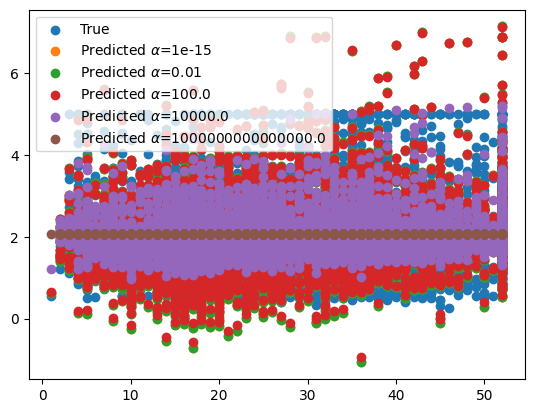

In [6]:

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
for alpha in [1e-15, 1e-2, 1e2, 1e4, 1e15]:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    err = MSE(y_pred, y_test)
    print("ALPHA:", alpha, "MSE:", err)

    plt.scatter(X_test_plot[:,1],y_pred,label=r'Predicted $\alpha$='+str(alpha))
plt.legend()

We can see that the value for $\alpha$ does not make a huge difference at small values, but as $\alpha$ starts to increase so does the error of the model. Figuring out this point where the error starts to increase is important so that we do not choose an $\alpha$ value higher than that.  However, in other data sets, a high degree of regularization could be needed, so choosing a value of $\alpha$ that is too low could also be detrimental to our model's performance.

While performing extensive hyperparameter tuning on a linear model like the ones we have studied so far may seem like overkill, beginning this week we will start looking at more complicated nonlinear models.  These nonlinear models have several hyperparamters and they models will be more sensitive to small changes in these parameters, so not only does hyperparameter tuning become more important, it also becomes more time extensive.  For the rest of this section of the lecture notes we will be looking at five different ways that can be used to find the optimal hyperparameter value for the ridge regression algorithm and now these method can be transferred to the more complicated linear models we will be studying for the remainder of the course.

### Methods for Hyperparameter Tuning

#### Using Default Values
All machine learning algorithms that are implemented in Scikit-Learn have default values for all of the hyperparameters. These are not neccessarily the best values, but using the defaults is the simplest method. 

For ridge regression, the default value of $\alpha$ is 1.0, which is a reasonably high level of regularization. Let's determine the performance of the default values on our housing data set. However, the entire housing data set is over 20,000 points, so in order to save time we will reduce the data set to just the first 1,000 points to perform hyperparameter tuning. This subset of the data set we use for the hyperparameter tuning is called the **validation data set**, and is either a subset of the entire data set or a subset of the training data set depending on the implementation.


In [7]:
# Make the data set smaller (20k+ points in total)
# More points = more data to generate patterns BUT more run time
X = X[:1000]
y = y[:1000]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [8]:
%%time
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

CPU times: user 1.65 ms, sys: 5.34 ms, total: 6.99 ms
Wall time: 21.1 ms


Not only are we interested in the accuracy of each tuning method, we also want to look at the run times. If a method can produce a very accurate method, but it has very high run times, it may not be the best choice.  Run time is even more important as we move to more complicated models and data sets. The `%%time` statement has to be the first line of the cell to produce the run time of the code cell. In this notebook we will be comparing the run times from just running each cell once, but in a true comparison of run times you will want to run each relevant cell many times and report the average run time as well as the standard deviation.  This also goes for reporting any errors/accuracy scores that have an element of randomness in them (such as the train-test split).  We will want to run the code many times to get an average accuracy over several possible data splits.

MSE: 0.37302197928508446


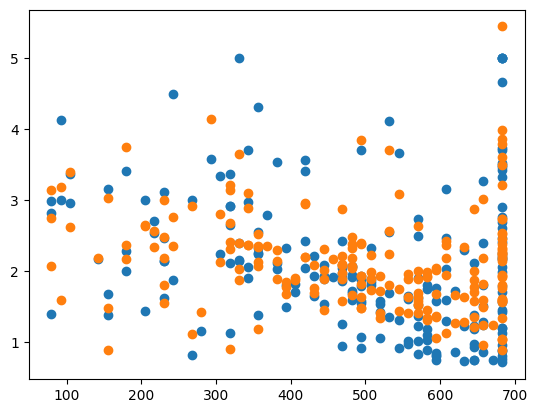

In [9]:
err = MSE(y_pred, y_test)
print("MSE:", err)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

The advantages of using the default values for the hyperparameters are that its a very fast method and it does not require any modifications to the code or algorithm.  However, the default values for the hyperparameters may not be the best values and no test are done to check to see if there are better values. The next three hyperparameter tuning methods we will look at check many different values (or combinations of values) to find the optimal set of hyperparameters.

#### For Loop Tuning

This is the the method we have been using for hyperparameter tuning so far, where we use a for loop to perform a brute force test over a given range of possible values to find the hyperparameter value that results in the lowest error (or highest accuracy score). If there is more than one hyperparameter, we can use nested for loops to check all possible combinations of hyperparameters in the ranges we are testing.

In [10]:
%%time
best_err = 1e4
best_alpha = None
for alpha in np.logspace(-15,4,1000):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    
    err = MSE(y_pred, y_test)
    
    if err < best_err:
        best_err = err
        best_alpha = alpha

CPU times: user 309 ms, sys: 12.6 ms, total: 322 ms
Wall time: 350 ms


MSE: 0.36479594459395437
CHOSEN ALPHA: 7.832382599179204e-15


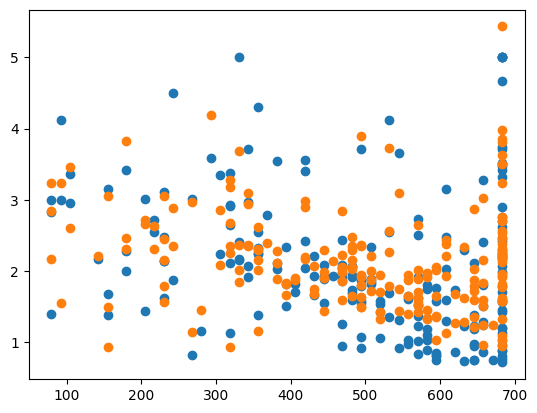

In [11]:
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print("CHOSEN ALPHA:", best_alpha)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

The advantages of the for loop method are that it checks more than one value of the hyperparameter to find the best value (it will check as many different values as we specify), its a simple concept that is relatively easy to implement, and it has short run times (compared to the next two methods). However, it is a long piece of code that grows longer as we have more hyperparamters to check and it does not check all possible values of the best hyperparameters, just the ones that are passed.

#### GridSearchCV (Scikit-Learn)

Scikit-Learn has several hyperparameter tuning implementations and we will be looking at two of them: [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). GridSearchCV is a brute force algorithm that checks every single hyperparameter it is given to find the best value, or every possible combination of hyperparameters if it is given more than one hyperparameter to optimize. This is the same process as the for loop tuning discussed in the last section, but GridSearchCV gives more information that the for loop implementation but it also has longer run times.  The below code applies GridSearchCV to our data set and extracts the best value of $\alpha$.  However, GridSearchCV has many more features that can be look at in the documenation (linked above).

In [12]:
%%time
from sklearn.model_selection import GridSearchCV

parameters = {'alpha':np.logspace(-15,4,5000)}

ridge = Ridge()

grid_search = GridSearchCV(ridge, parameters,\
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'alpha': 0.32456542994104964}
CPU times: user 13.1 s, sys: 105 ms, total: 13.2 s
Wall time: 13.4 s


MSE: 0.36836742859149213
CHOSEN ALPHA: 0.32456542994104964


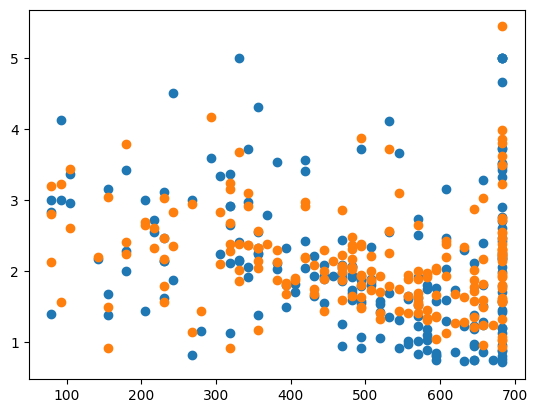

In [13]:
ridge = Ridge(alpha=grid_search.best_params_['alpha'])
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', grid_search.best_params_['alpha'])

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

The advantages of GridSearchCV is that it takes only a few lines of code to implement, and it gives you a lot of data on the fits once you train the algorithm.  However, GridSearchCV has very long run times compared to the previous two methods, and, like the for loop method, it only searches over a given range of parameters and does not consider other values (that could be better fits).

#### RandomizedSearchCV

RandomizedSearchCV takes a different approach. Instead of performing a brute force search over a given range of parameters, it randomly draws a given number of points from a distribution. In the below example, we are sampling points from a uniform distribution, but there are other options as well avalible [here](https://docs.scipy.org/doc/scipy/reference/stats.html) under the "Continuous distributions" heading. We choose the number of randomly sampled points by setting the `n_iter` argument.  Below, we are setting it to 5,000 points so that it is comparing the same number of values as the previous two methods so the run times are comparable.

In [14]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

distributions = {'alpha':uniform(loc=0, scale=4)}

ridge = Ridge()

random_search = RandomizedSearchCV(ridge, distributions,\
                                   scoring='neg_mean_squared_error', n_iter=5000)
random_search.fit(X_train, y_train)

print(random_search.best_params_, random_search.best_score_)

{'alpha': 0.32388576420344695} -0.27909689923589065
CPU times: user 13.8 s, sys: 224 ms, total: 14 s
Wall time: 14.8 s


MSE: 0.3683611387273003
CHOSEN ALPHA: 0.32388576420344695


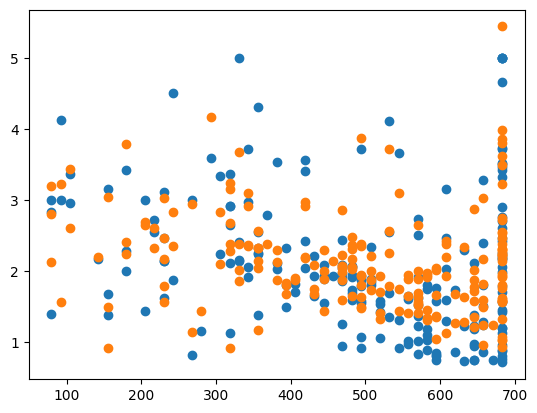

In [15]:
ridge = Ridge(alpha=random_search.best_params_['alpha'])
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', random_search.best_params_['alpha'])

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

The advantages of the RandomizedSearchCV method are the same as GridSearchCV (only a few line implementation and it gives a lot of data once it is trained). Additionally, unlike the for loop method and GridSearchCV, since this method draws points from a distribution, it is not constrained to a given range of values the user passes. However, it also has long run times.  This can be changed by lowering the `n_iter` value, but smaller values mean less values are tested.  Additionally, like the previous methods, it only searches a finite number of parameter combinations. 

#### Bayesian Ridge Regression

Bayesian ridge regression belongs to a classification of  machine learning algorithms called [Bayesian machine learning](https://machinelearningmastery.com/bayes-theorem-for-machine-learning/). Instead of using "normal" stastics to fit the models Bayesian machine learning makes use of [Bayesian statistics](https://en.wikipedia.org/wiki/Bayesian_statistics), which is based on [Bayes Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem).

Bayesian ridge regression uses Bayesian statistics to find the value of $\alpha$ that is statistically likely to result in the best model. This fixes the problems of the previous models where we could only search a finite number of values. We will not go into detail about how the Bayesian ridge regression algorithm determines the best value of $\alpha$, but if you are interested, the following links are a good starting place:

* [Scikit-Learn's website](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression)
* [Building Block AI](https://buildingblock.ai/bayesian-ridge-regression)
* [Towards Data Science](https://towardsdatascience.com/how-to-build-a-bayesian-ridge-regression-model-with-full-hyperparameter-integration-f4ac2bdaf329)


You will get different results when performing Bayesian ridge regresion compared to linear regression or ridge regression, and the results may not be as accurate as a throughly tuned ridge regression model. However, Bayesian ridge regression is much more robust than regular ridge regression and performs it hyperparameter tuning automatically.

In [16]:
%%time
from sklearn.linear_model import BayesianRidge

bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)
y_pred = bayesian_ridge.predict(X_test)

print(bayesian_ridge.alpha_)

3.7037277070209402
CPU times: user 2.51 ms, sys: 18.5 ms, total: 21 ms
Wall time: 97 ms


MSE: 0.3748372426719787
CHOSEN ALPHA: 3.7037277070209402


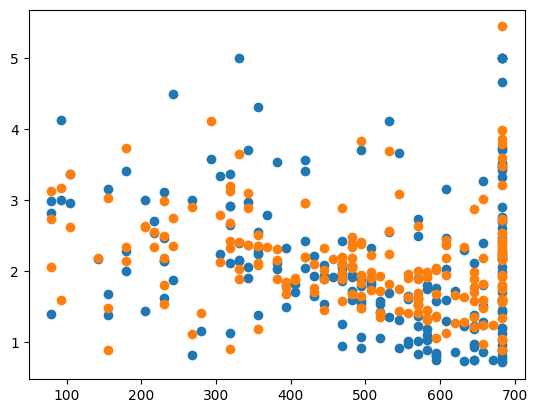

In [17]:
ridge = BayesianRidge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', ridge.alpha_)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

Bayesian ridge regression has very short run times and you can be sure that you have found the statistically best value of $\alpha$, instead of just the best value in a given finite range. It also only takes a couple of lines of code to implement. Unfortunately, Bayesian ridge regression only works for ridge regression (unlike the previous models which can be extended to other machine learning algorithms), but there are Bayesian machine learning implementations of most common machine learning algorithhms. [Gaussian processes](https://scikit-learn.org/stable/modules/gaussian_process.html) can be considered the Bayesian implementation of several nonlinear models, such as kernel ridge regression we will look at later in these notes. [Bayesian Neural Networks](https://arxiv.org/pdf/2007.06823.pdf) are the Bayesian implementation of neural networks.

## Part II: Feature Optimization

